In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchinfo import summary
import torch.optim as optim
from torch.utils.data import DataLoader,Dataset
import torch.utils.data as data
from torchvision import transforms
import torchvision

import sys,os
sys.path.append(os.pardir)

import py_func.Deep_learning_torch_func as DL
import py_func.models_func as my_model
import py_func.dat_rb_func as drb
import py_func.my_numpy_class as mnc
import py_func.my_torch_class as mtc
import py_func.models_func as my_model

import py_func.Deep_learning_torch_func as DL
import py_func.dat_rb_func as drb

from torchinfo import summary

from torch.optim import lr_scheduler

import numpy as np
import os.path as osp
import importlib

### FashionMNIST simulation dataset 68000train not shuffle

In [2]:
outputdir = "../output/sim/SLM_phase/fm"
howdatadir = osp.join(outputdir, "decode/68000train/")

datapath = '../dat/simdat/SLM_phase/1byte/lsd/fm/fm_4cm_4cm_3.3mm_notpad_4096x2400_samevalue_sclup_to8192x4800_sim.dat'
labelpath='../dat/bindat/fm_28_1.dat'

# shfldir= "../output/experiment/SLM_phase"
# shflidpath=osp.join(shfldir, "shuffle_first_68000.npy")
# trainid = np.load(file=shflidpath)
# shflidpath=osp.join(shfldir, "shuffle_68001_69000.npy")
# valid = np.load(file=shflidpath)
# shflidpath=osp.join(shfldir, "shuffle_69001_70000.npy")
# testid = np.load(file=shflidpath)

In [3]:
fm = mnc.My_numpy(1, datapath)
fm.simread(70000, 4096)
print(fm.data.shape)

fm.data = fm.data.reshape(70000, 1, 4096)
print(fm.data.shape)
data=fm.data[:,:,int(4096/2)-int(1600/2):int(4096/2)+int(1600/2)]
print(data.shape)


fmimg = mnc.My_numpy(1, labelpath)
fmimg.binread(70000, 28, 28)
fmimg.data = fmimg.data.reshape(70000, 1, 28, 28)
print(fmimg.data.shape)

myset = mtc.My_dataset2(data, fmimg.data)
myset.numpy2tensor()
trainlist, vallist, testlist = myset.splitdata(68000, 1000, 1000)

myset.set3data(trainlist[0], val=vallist[0], test=testlist[0])
myset.set3label(trainlist[1], val=vallist[1], test=testlist[1])

myset.datanormalize()
myset.labelnormalize()
myset.tensor2dataset()

batch=256
mlt = DataLoader(myset.dataset_train, batch_size = batch, shuffle = True)
mlv = DataLoader(myset.dataset_val, batch_size = batch, shuffle = False)
mltest = DataLoader(myset.dataset_test, batch_size = batch, shuffle = False)

print(len(mlt), len(mlv), len(mltest))

(70000, 4096)
(70000, 1, 4096)
(70000, 1, 4096)
(70000, 1, 28, 28)
266 4 4


In [4]:
data.shape

(70000, 1, 1600)

In [5]:
criterion = nn.MSELoss()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

#model_ver3
#28x28出力
kernel_size = [4,4,4,4]
stride_list = [1,1,1,1]
padding_list = [4,4,2,2]
outpadding_list = [0,0,0,0]
in_channel_list = [1, 32, 64, 128]
out_channel_list = [32, 64, 128, 1]

model = my_model.decoder_allsize(1600, 1600, 40, 40, kernel_size, stride_list, padding_list,
                                        outpadding_list, in_channel_list, out_channel_list).to(device)

### MSE lr1e-05 simulation 600epoch

-----------------------------epoch1--------------------------------
epochtime:0.3194 minutes
 train_loss:0.2611, val_loss:0.2659
-----------------------------epoch2--------------------------------
epochtime:0.2811 minutes
 train_loss:0.2057, val_loss:0.2085
-----------------------------epoch3--------------------------------
epochtime:0.2798 minutes
 train_loss:0.1814, val_loss:0.1835
-----------------------------epoch4--------------------------------
epochtime:0.2831 minutes
 train_loss:0.1661, val_loss:0.1678
-----------------------------epoch5--------------------------------
epochtime:0.2814 minutes
 train_loss:0.1553, val_loss:0.1567
-----------------------------epoch6--------------------------------
epochtime:0.2801 minutes
 train_loss:0.1471, val_loss:0.1487
-----------------------------epoch7--------------------------------
epochtime:0.2804 minutes
 train_loss:0.1405, val_loss:0.1418
-----------------------------epoch8--------------------------------
epochtime:0.2779 minutes
 tra

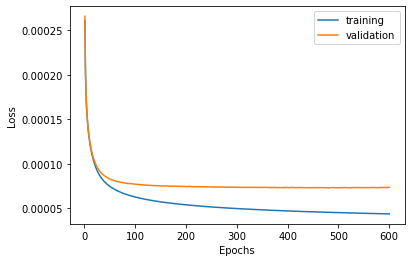

In [6]:
lrdir = osp.join(howdatadir, "lr1e-05")
modelsavedir = osp.join(lrdir, "MSE")
md_path = osp.join(modelsavedir, 'm68000_1600_MSE.pth')

optimizer = optim.Adam(model.parameters(), lr=0.00001)
#scheduler = lr_scheduler.StepLR(optimizer, step_size = 75, gamma=0.5)

epochs = 600


#training
tl, vl = DL.train_decode_model_ver2(mlt, mlv, model, criterion, optimizer, \
                                    epochs, device, \
            modelsavedir = modelsavedir, saveepoch = 50, saveinterval = 50)

torch.save(model.state_dict(), md_path)
DL.learning_curv_ver2( 12, 4, 10, 10, tls = tl, vls = vl)



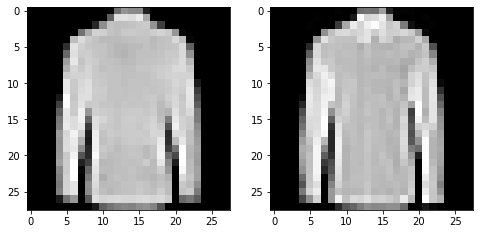

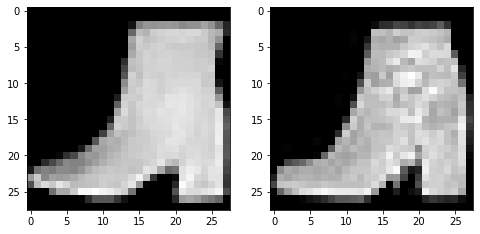

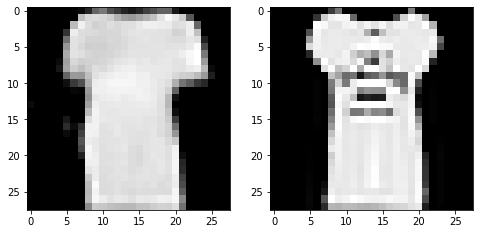

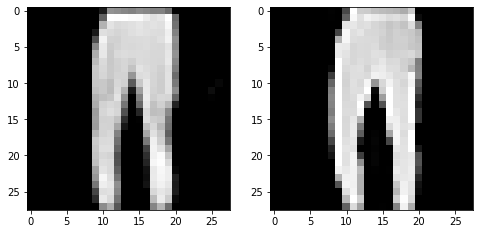

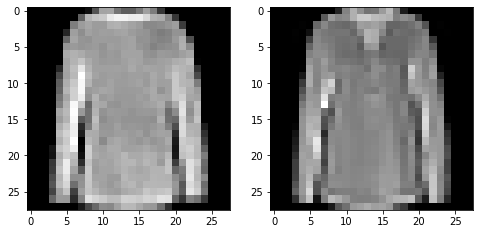

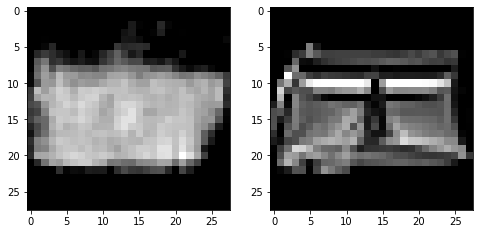

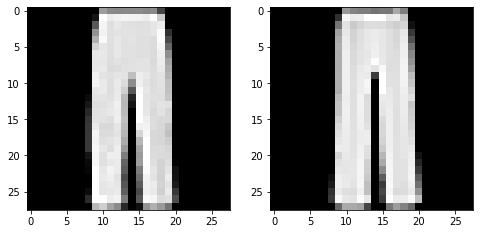

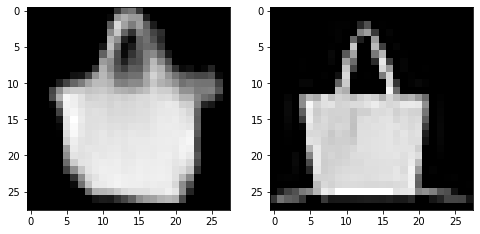

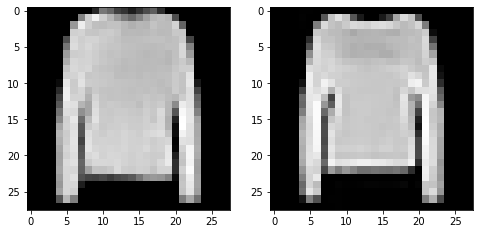

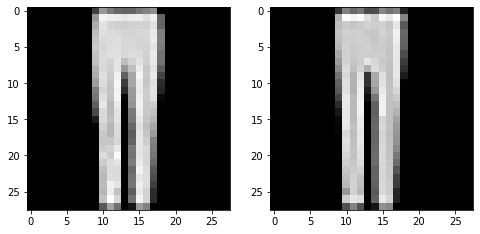

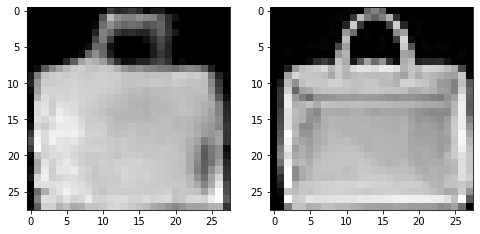

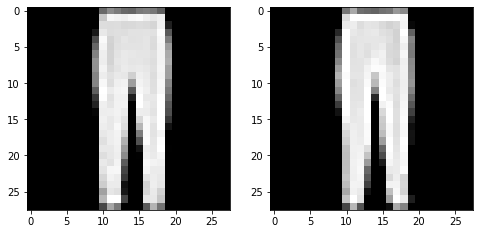

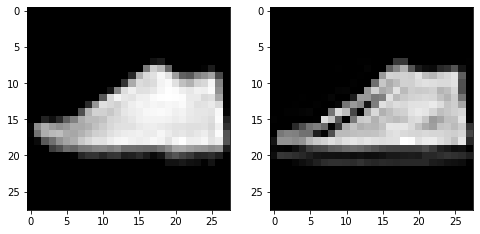

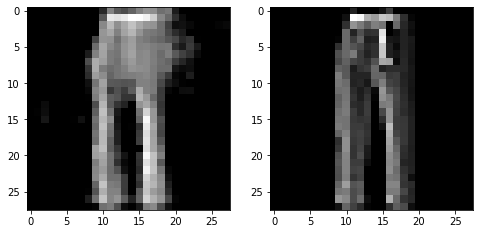

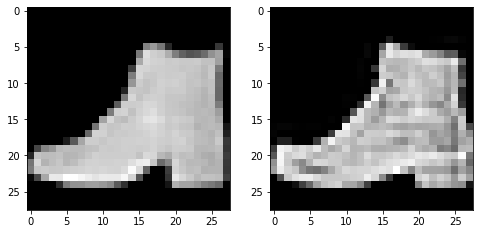

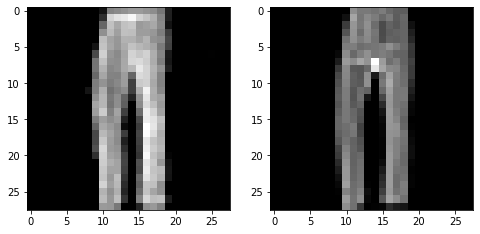

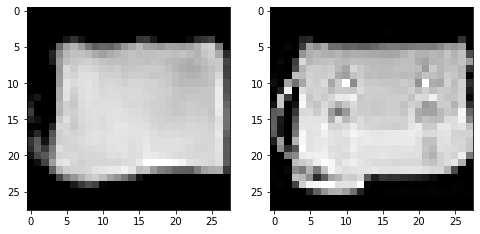

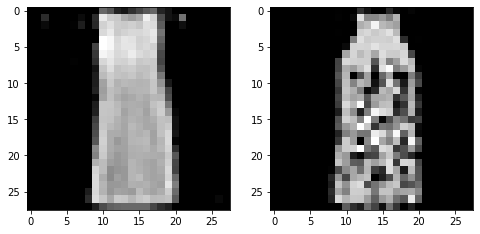

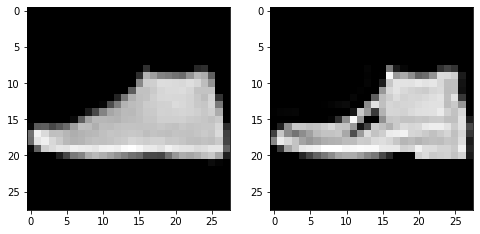

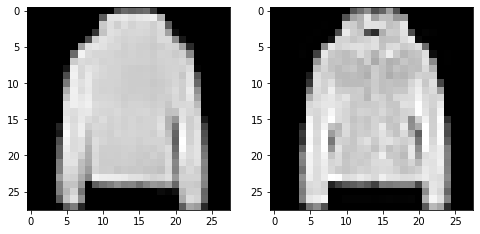

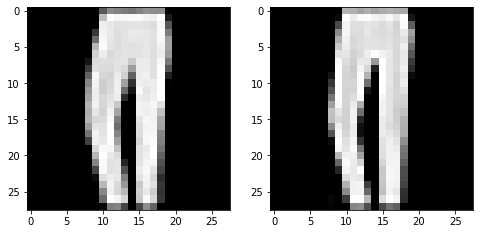

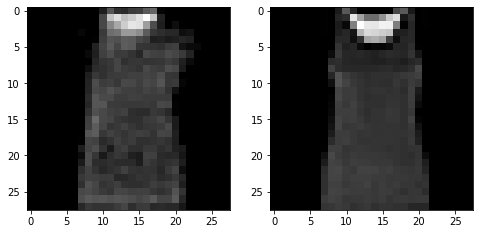

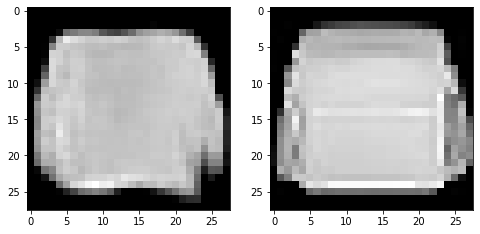

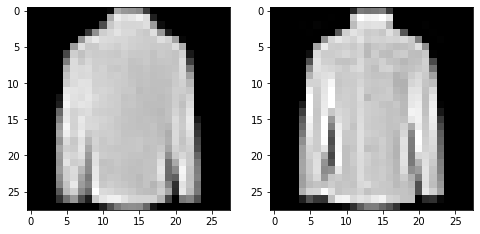

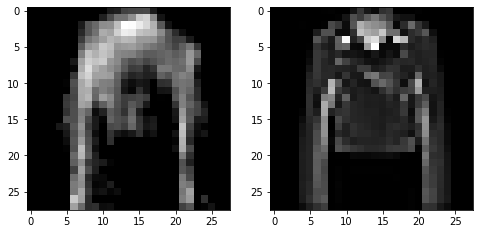

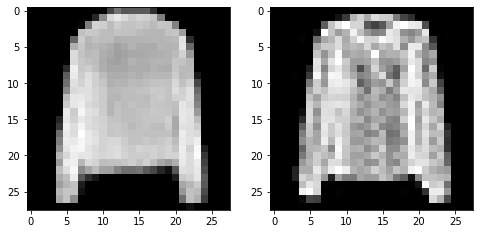

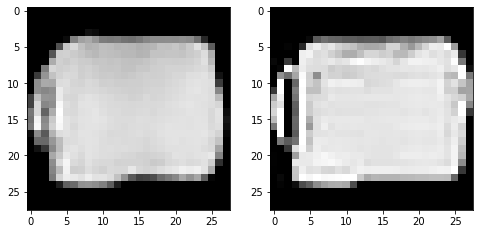

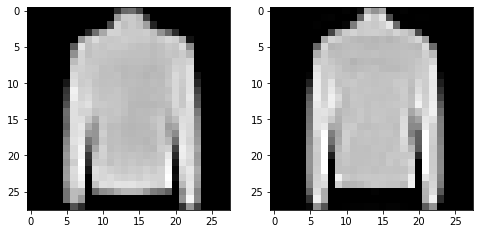

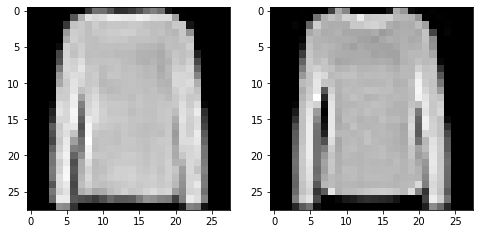

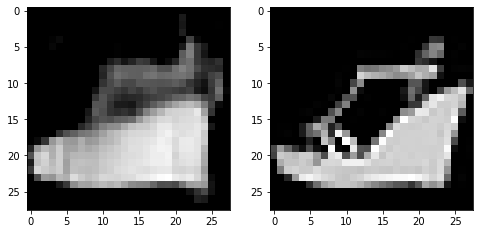

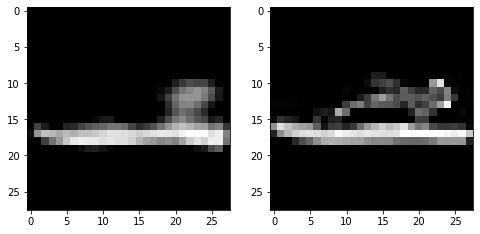

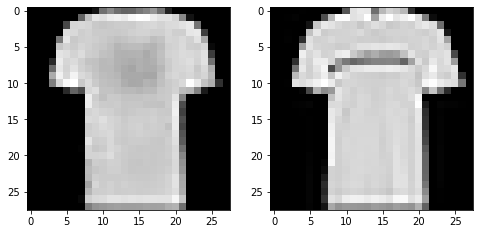

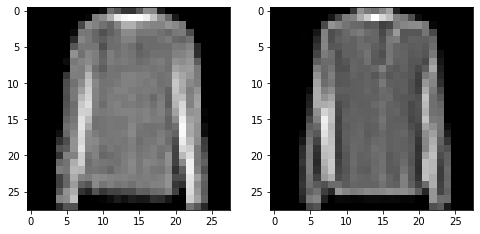

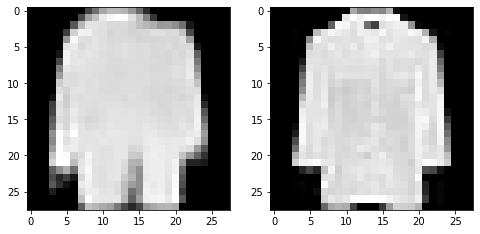

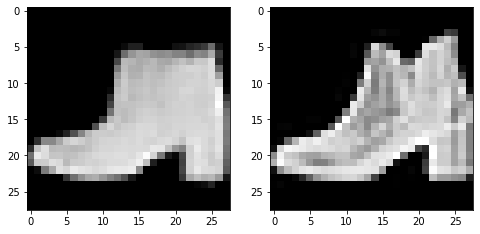

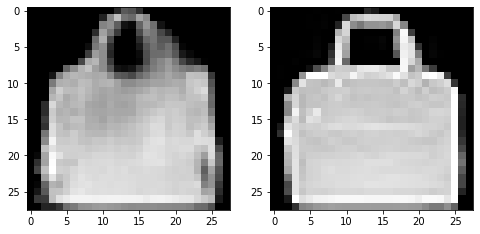

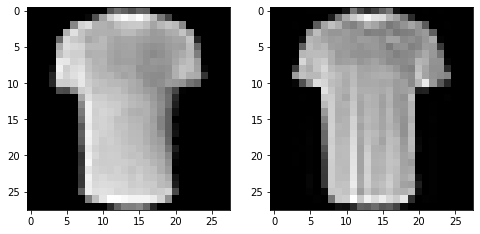

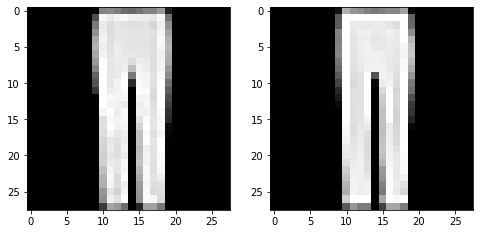

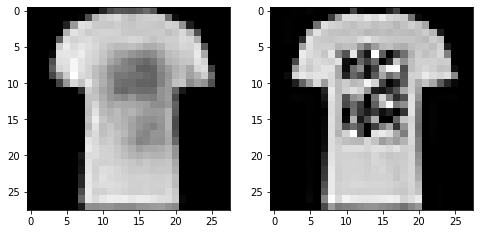

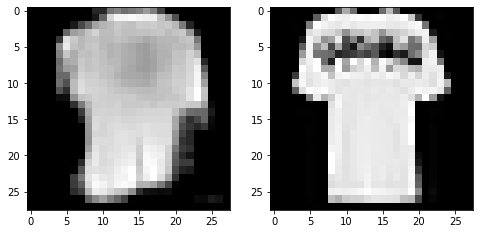

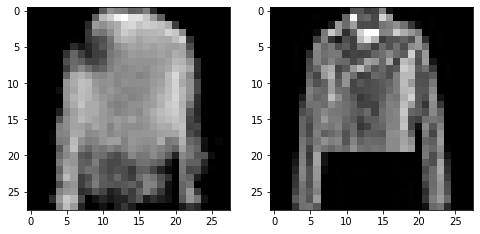

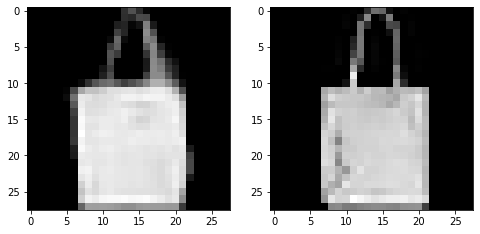

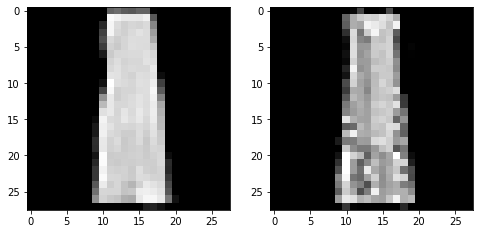

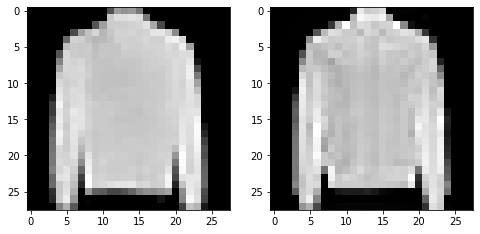

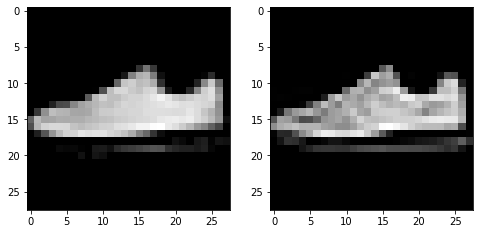

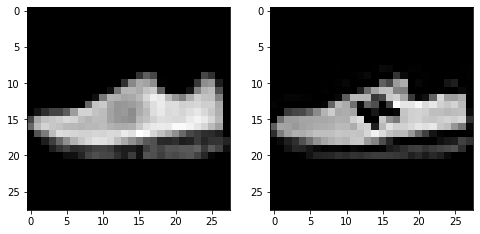

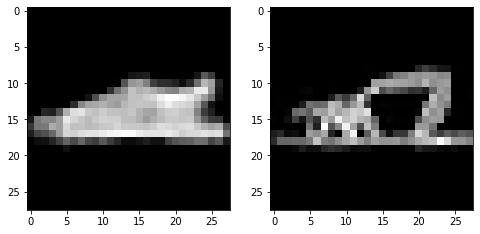

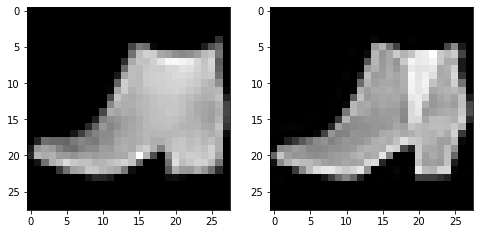

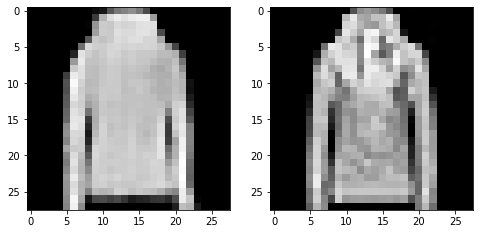

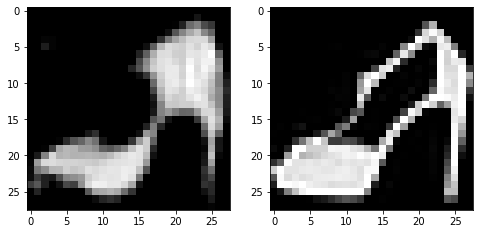

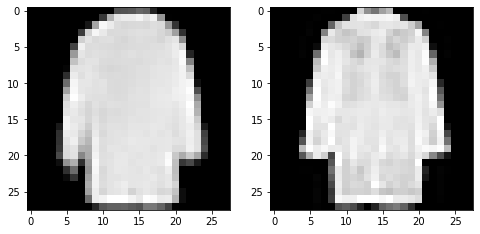

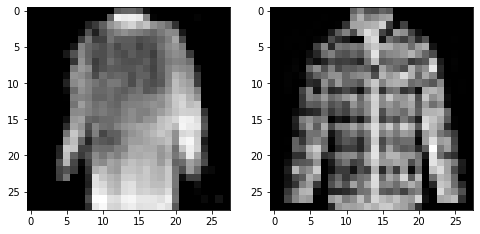

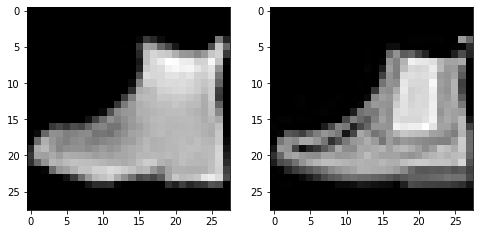

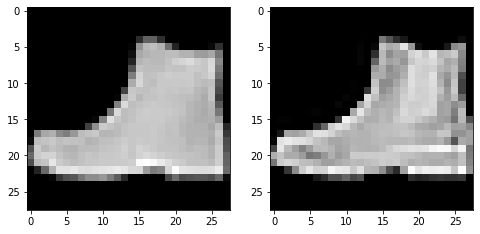

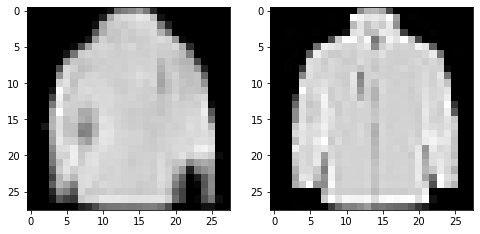

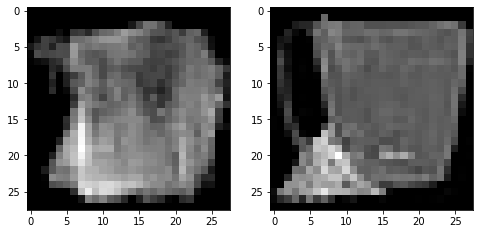

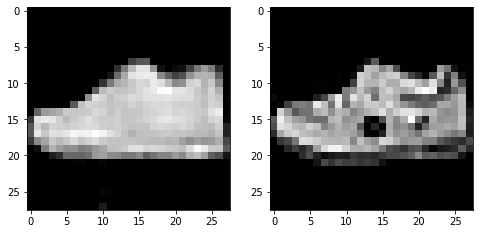

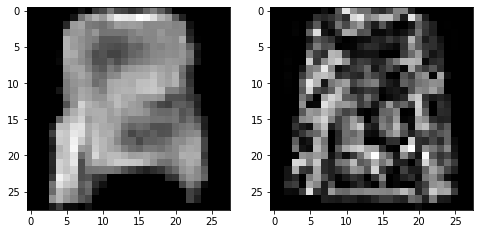

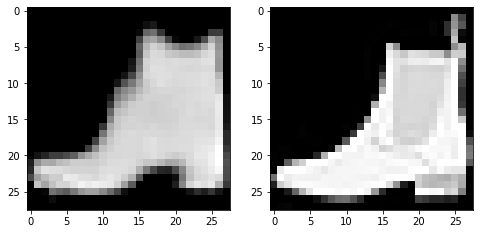

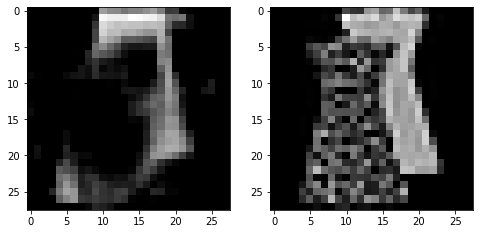

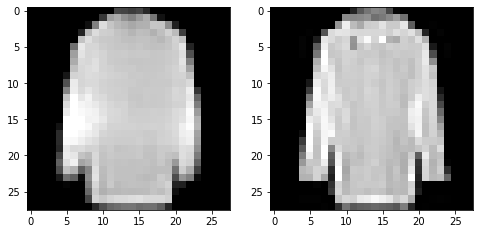

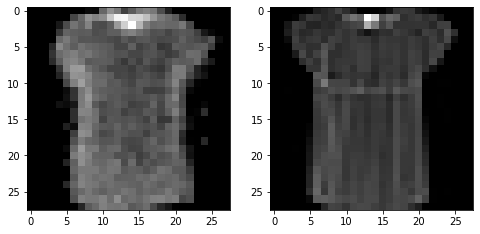

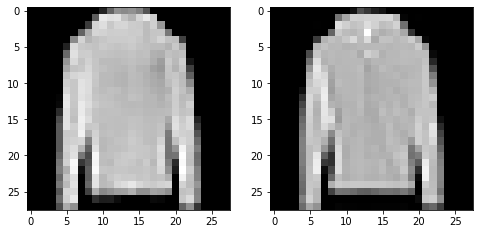

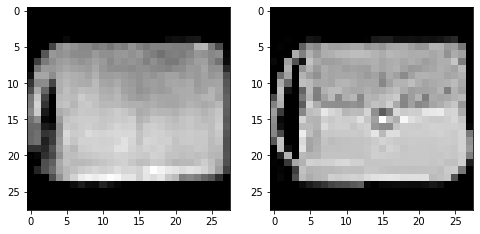

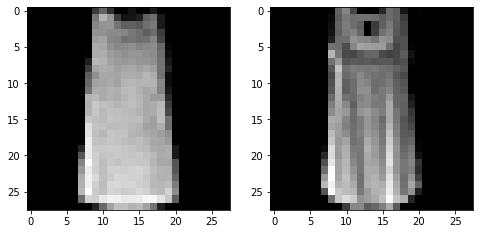

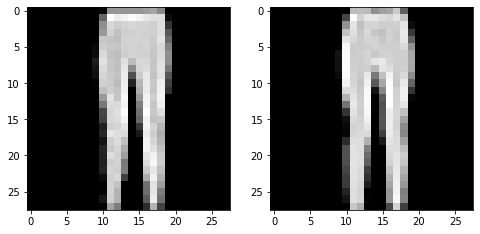

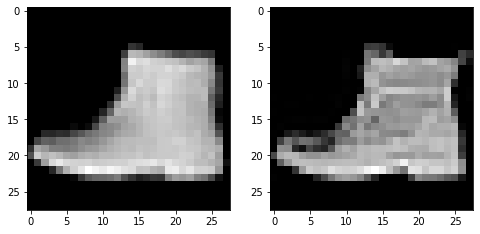

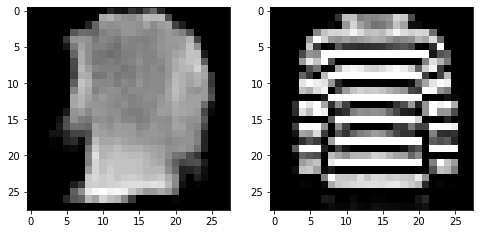

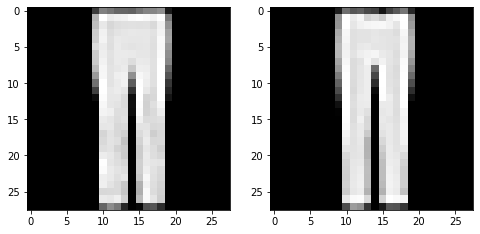

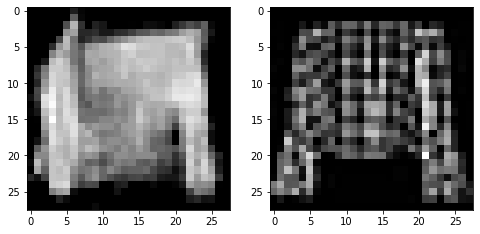

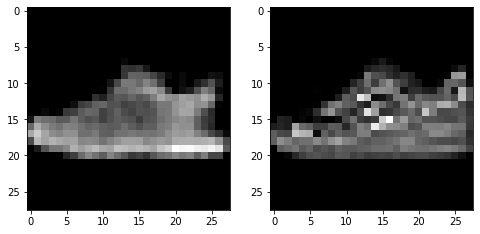

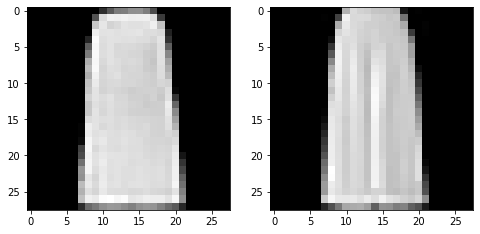

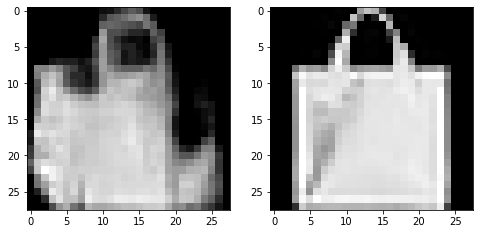

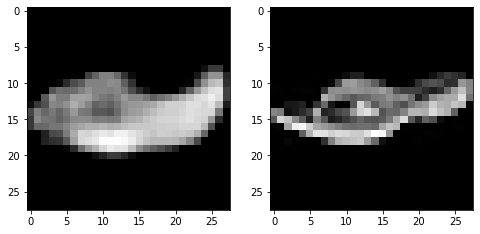

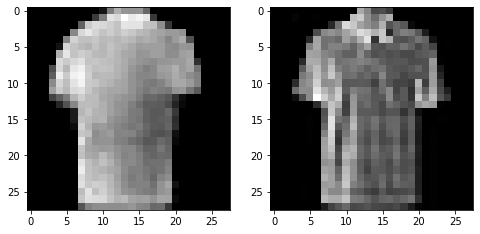

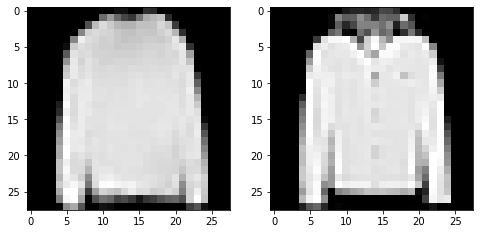

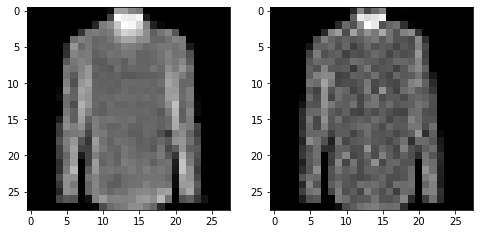

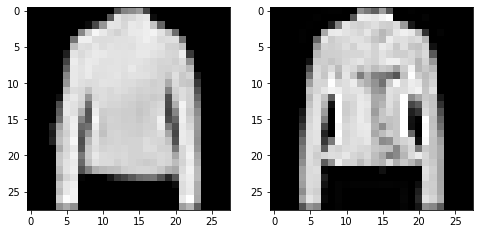

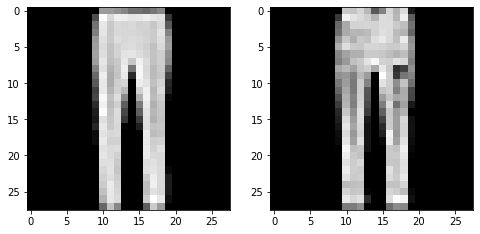

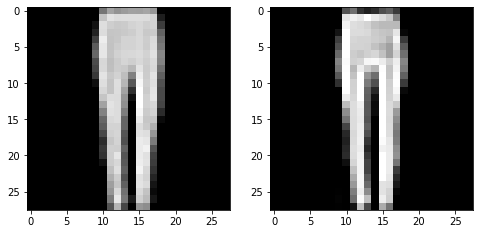

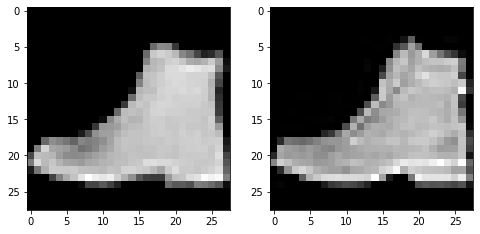

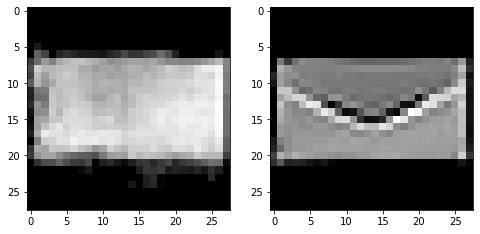

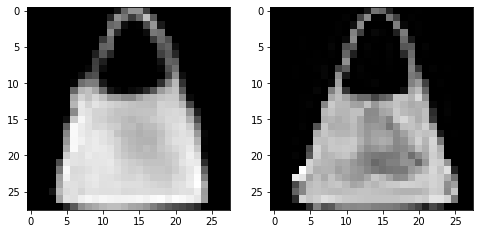

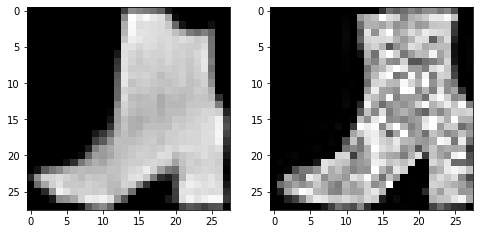

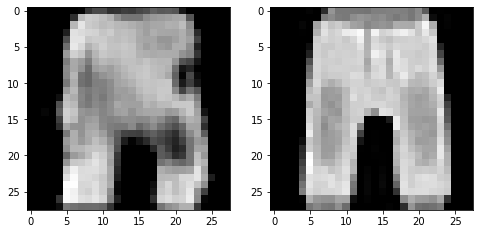

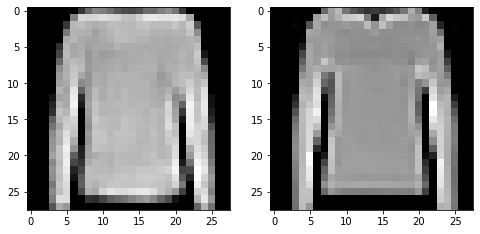

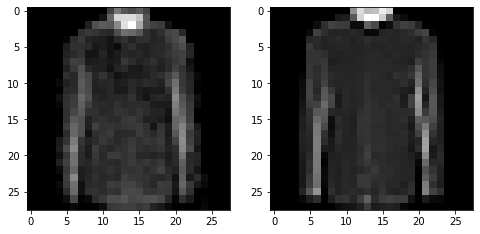

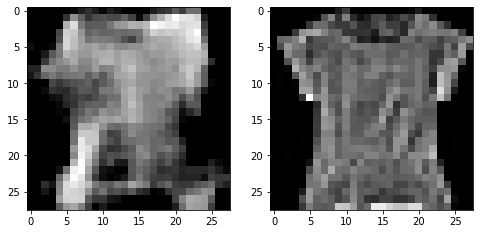

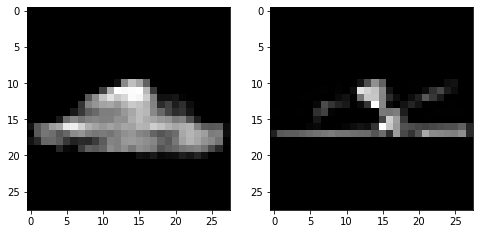

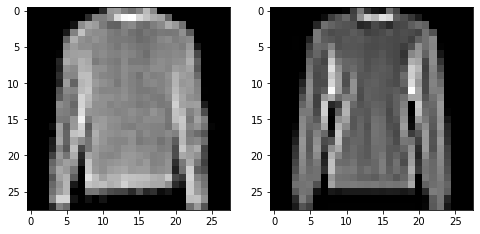

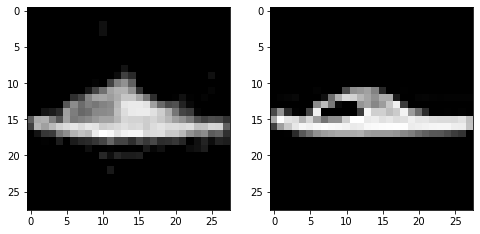

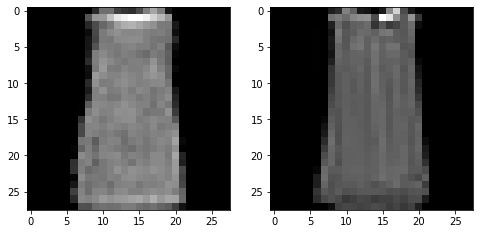

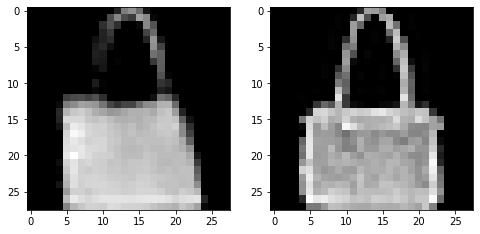

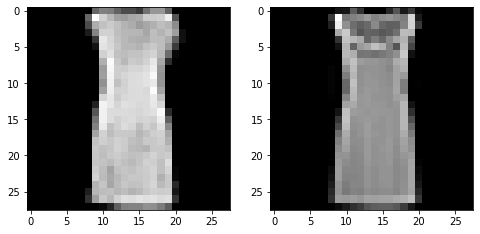

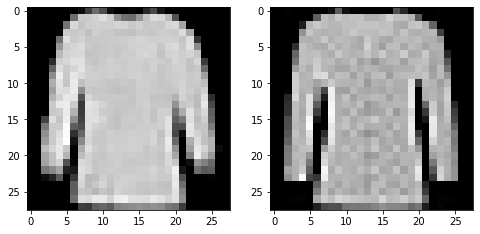

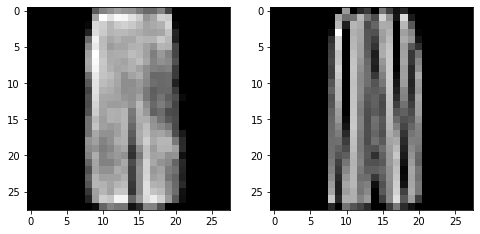

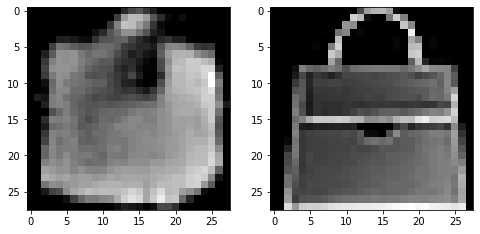

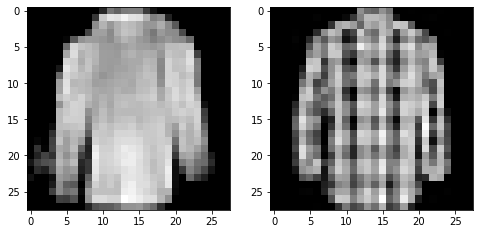

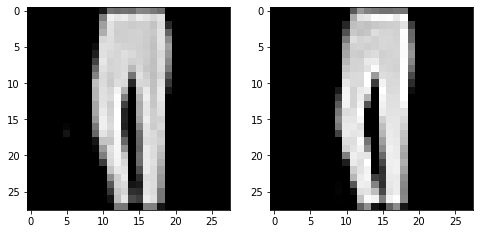

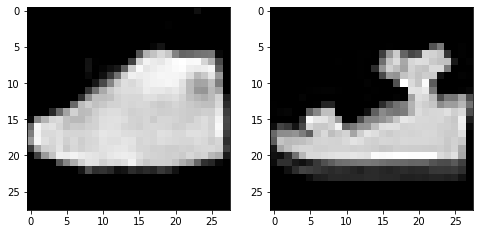

18.314051281743456 0.666974868581013


In [7]:
imgpath = osp.join(modelsavedir, 'img')
psnrs, ssims = DL.test_decode_model_and_check_img_ver3(mltest, 28, 28, model, device, 8, 4, 1, 100, imgpath, \
                                                label_array = None, datanorm = True, correctimgnorm = True)
meanpsnr = np.mean(np.array(psnrs))
meanssim = np.mean(np.array(ssims))

print(meanpsnr, meanssim)

### FashionMNIST experiment dataset 68000train shuffle

In [8]:
outputdir = "../output/experiment/SLM_phase/fm"
howdatadir = osp.join(outputdir, "decode/midline_randomshuffle_68000train/")

datapath = '../dat/experiment/SLM/fm_6_18/fm_1_70000_slt0.4_0.8_N3_lsd_midline.dat'
labelpath='../dat/bindat/fm_28_1.dat'

shfldir= "../output/experiment/SLM_phase"
shflidpath=osp.join(shfldir, "shuffle_first_68000.npy")
trainid = np.load(file=shflidpath)
shflidpath=osp.join(shfldir, "shuffle_68001_69000.npy")
valid = np.load(file=shflidpath)
shflidpath=osp.join(shfldir, "shuffle_69001_70000.npy")
testid = np.load(file=shflidpath)

In [9]:
fm = mnc.My_numpy(1, datapath)
fm.simread(70000, 1600)
print(fm.data.shape)

fm.data = fm.data.reshape(70000, 1, 1600)
print(fm.data.shape)

fmimg = mnc.My_numpy(1, labelpath)
fmimg.binread(70000, 28, 28)
fmimg.data = fmimg.data.reshape(70000, 1, 28, 28)
print(fmimg.data.shape)

myset = mtc.My_dataset2(fm.data, fmimg.data)
myset.numpy2tensor()
traindata, trainlabel = myset.index_splitdata(trainid)
valdata, vallabel = myset.index_splitdata(valid)
testdata, testlabel = myset.index_splitdata(testid)

myset.set3data(traindata, val=valdata, test=testdata)
myset.set3label(trainlabel, val=vallabel, test=testlabel)

myset.datanormalize()
myset.labelnormalize()
myset.tensor2dataset()

batch=256
mlt = DataLoader(myset.dataset_train, batch_size = batch, shuffle = True)
mlv = DataLoader(myset.dataset_val, batch_size = batch, shuffle = False)
mltest = DataLoader(myset.dataset_test, batch_size = batch, shuffle = False)

print(len(mlt), len(mlv), len(mltest))

(70000, 1600)
(70000, 1, 1600)
(70000, 1, 28, 28)
266 4 4


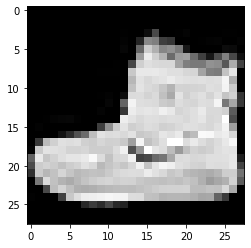

In [12]:
from matplotlib import pylab as plt

plt.imshow(fmimg.data[0][0])

In [13]:
criterion = nn.MSELoss()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

#model_ver3
#28x28出力
kernel_size = [4,4,4,4]
stride_list = [1,1,1,1]
padding_list = [4,4,2,2]
outpadding_list = [0,0,0,0]
in_channel_list = [1, 32, 64, 128]
out_channel_list = [32, 64, 128, 1]

model = my_model.decoder_allsize(1600, 1600, 40, 40, kernel_size, stride_list, padding_list,
                                        outpadding_list, in_channel_list, out_channel_list).to(device)

### MSE lr1e-05 experiment 600epoch

Exception ignored in: <function My_numpy.__del__ at 0x7f835566aea0>
Traceback (most recent call last):
  File "../py_func/my_numpy_class.py", line 118, in __del__
    del self.data
AttributeError: data


-----------------------------epoch1--------------------------------
epochtime:0.5367 minutes
, train_loss:0.3617, val_loss:0.3718
-----------------------------epoch2--------------------------------
epochtime:0.5283 minutes
, train_loss:0.3218, val_loss:0.3329
-----------------------------epoch3--------------------------------
epochtime:0.4906 minutes
, train_loss:0.2933, val_loss:0.3036
-----------------------------epoch4--------------------------------
epochtime:0.5224 minutes
, train_loss:0.2753, val_loss:0.2853
-----------------------------epoch5--------------------------------
epochtime:0.5190 minutes
, train_loss:0.2633, val_loss:0.2723
-----------------------------epoch6--------------------------------
epochtime:0.5217 minutes
, train_loss:0.2543, val_loss:0.2633
-----------------------------epoch7--------------------------------
epochtime:0.4659 minutes
, train_loss:0.2468, val_loss:0.2550
-----------------------------epoch8--------------------------------
epochtime:0.4653 minut

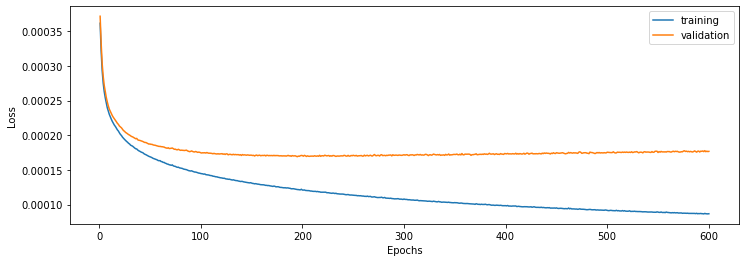

In [14]:
lrdir = osp.join(howdatadir, "lr1e-05")
modelsavedir = osp.join(lrdir, "MSE")
md_path = osp.join(modelsavedir, 'm68000_1600_MSE.pth')

optimizer = optim.Adam(model.parameters(), lr=0.00001)
#scheduler = lr_scheduler.StepLR(optimizer, step_size = 75, gamma=0.5)

epochs = 600


#training
tl, vl = DL.train_decode_model_ver2(mlt, mlv, model, criterion, optimizer, \
                                    epochs, device, \
            modelsavedir = modelsavedir, saveepoch = 50, saveinterval = 50)

torch.save(model.state_dict(), md_path)
DL.learning_curv_ver2( 12, 4, 10, 10, tls = tl, vls = vl)



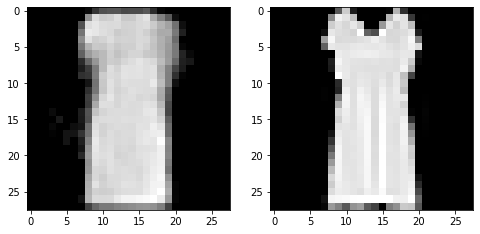

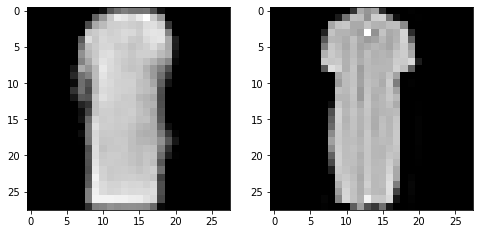

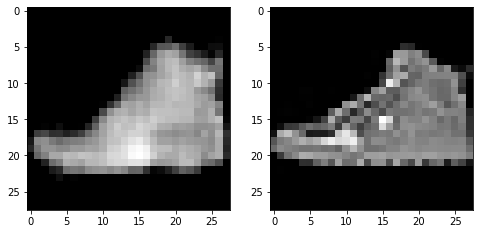

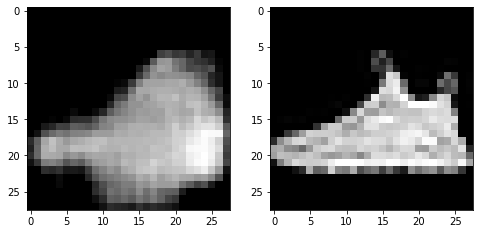

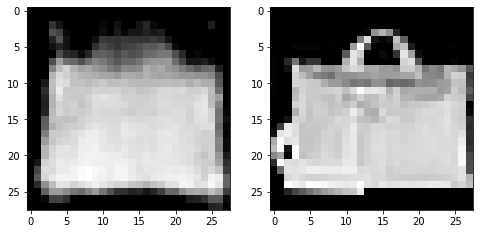

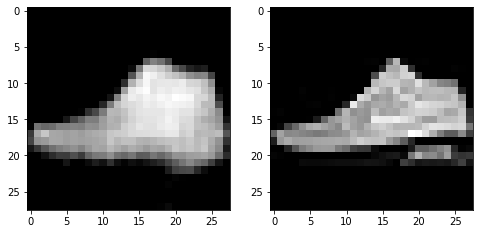

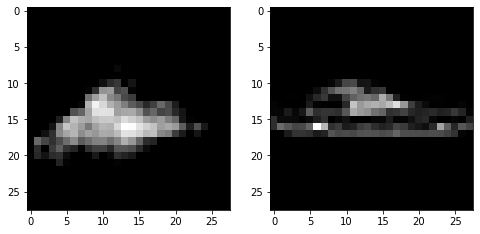

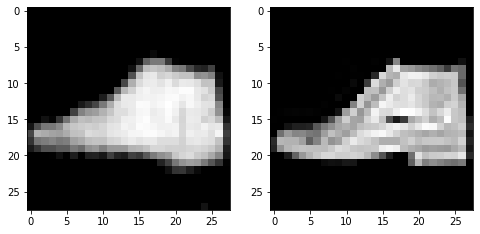

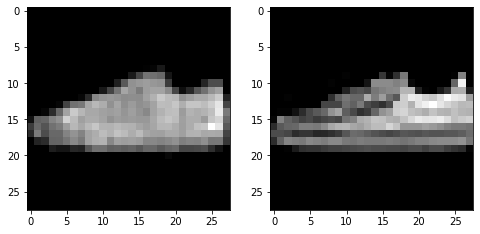

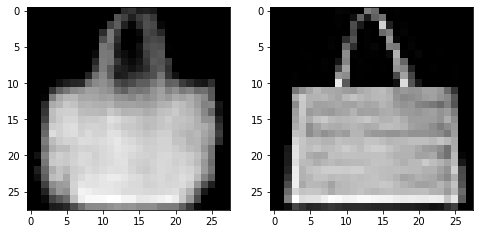

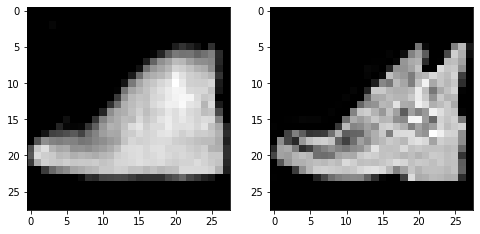

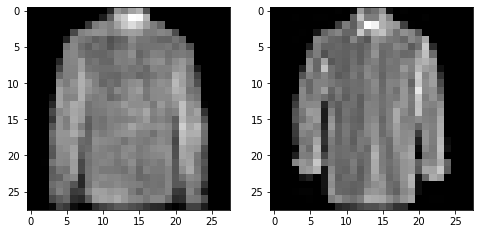

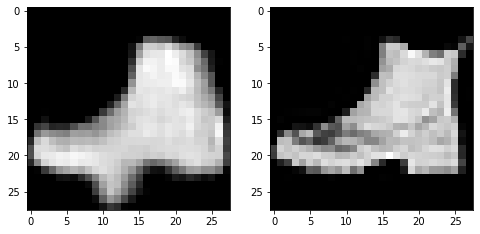

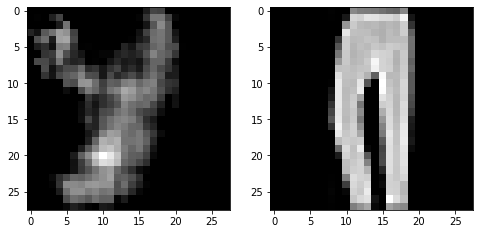

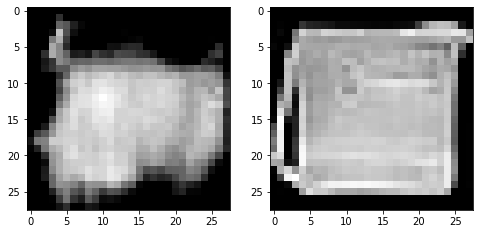

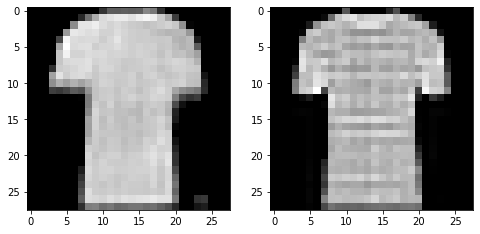

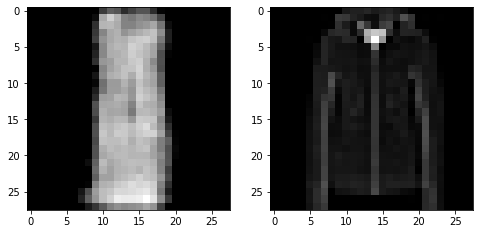

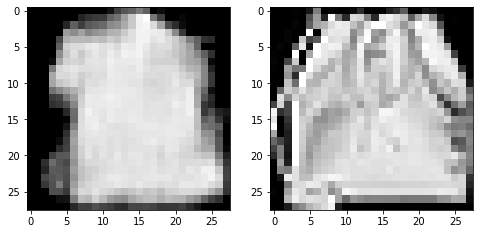

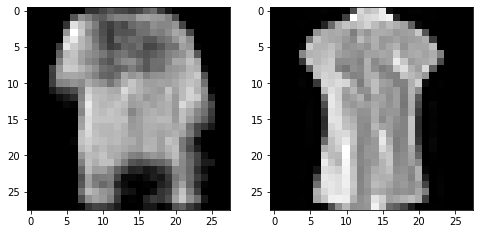

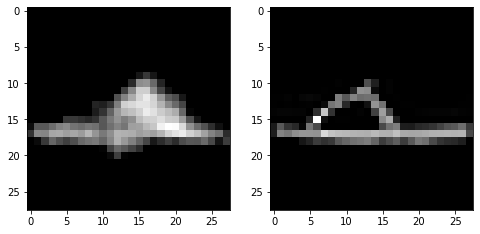

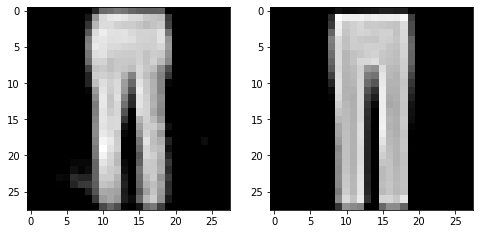

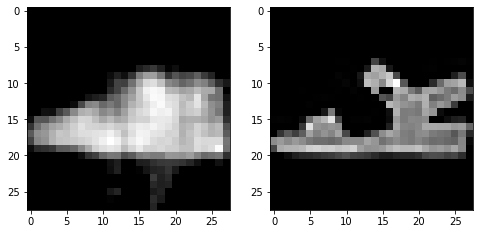

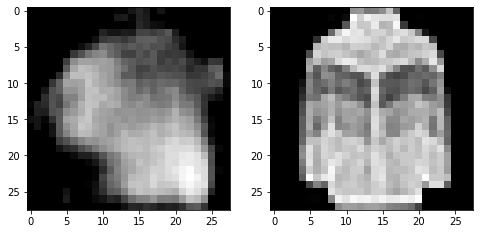

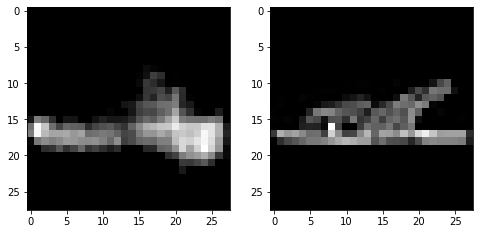

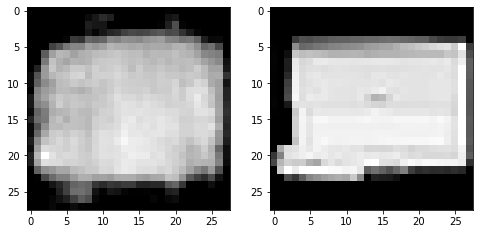

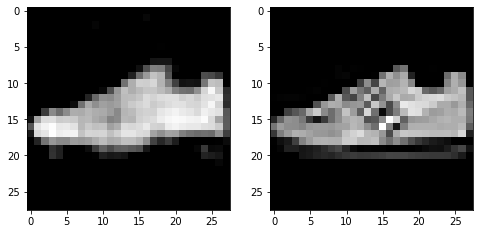

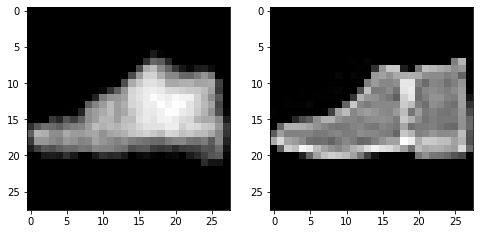

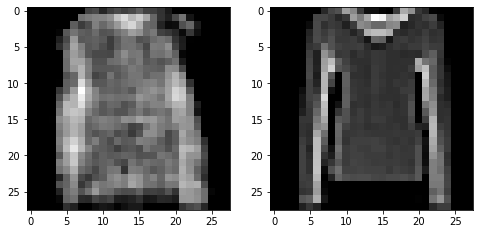

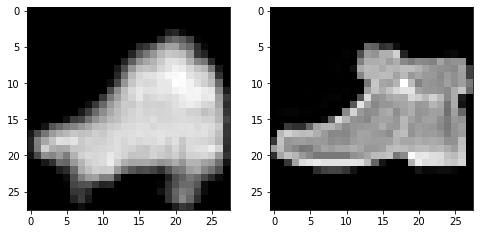

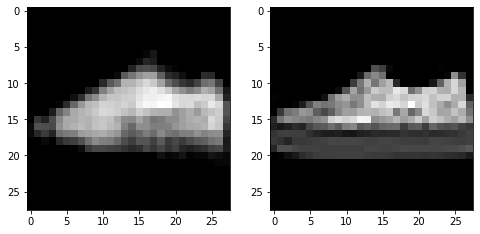

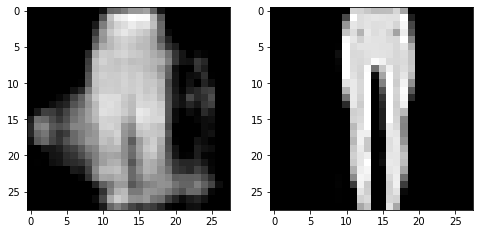

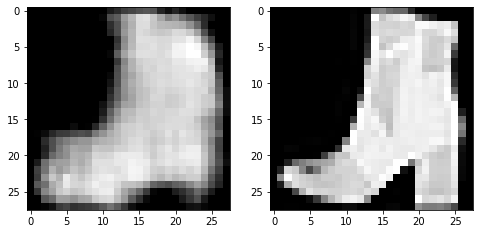

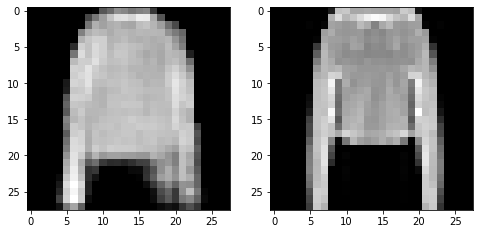

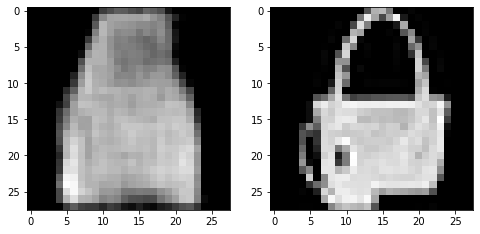

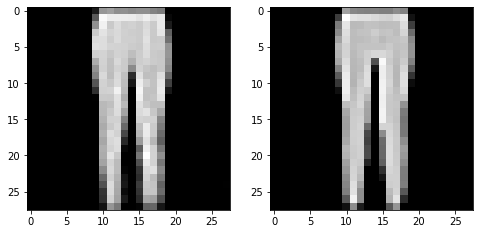

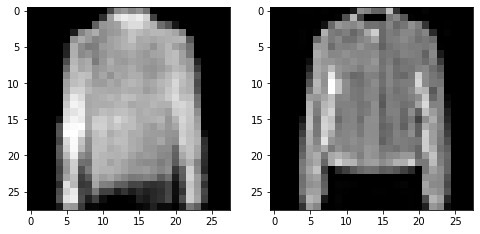

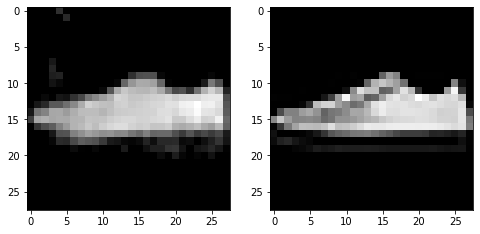

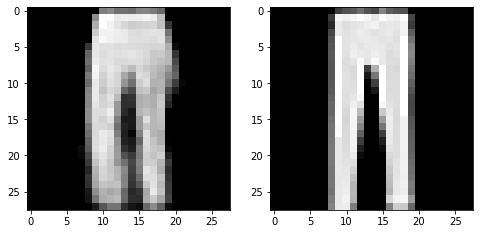

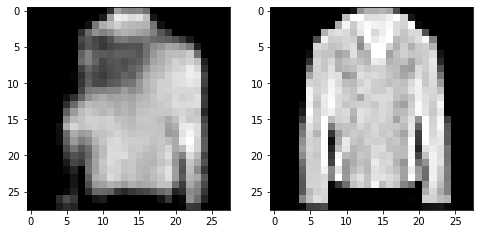

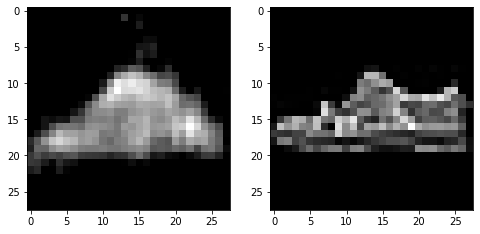

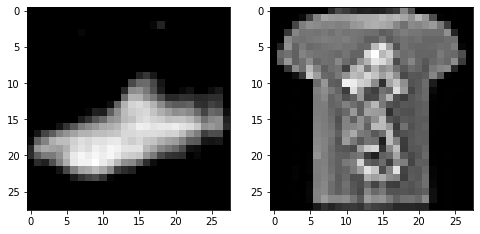

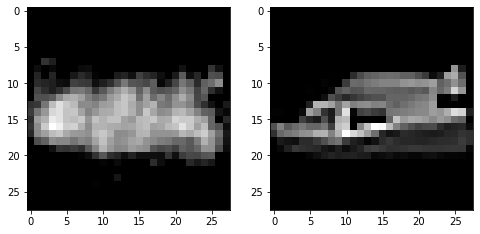

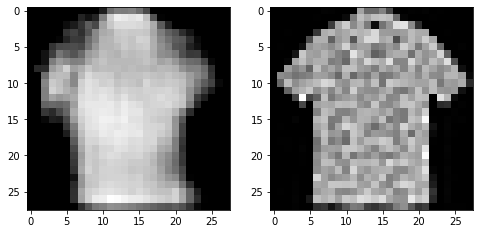

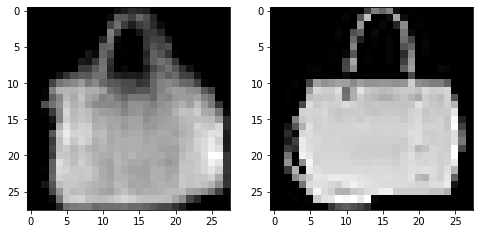

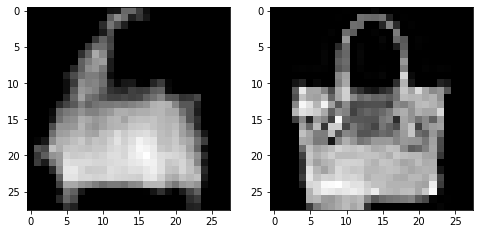

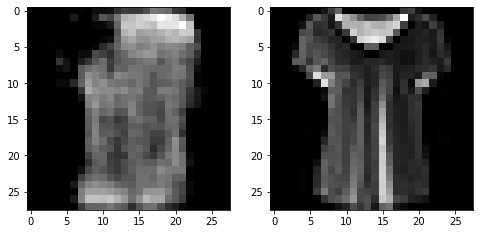

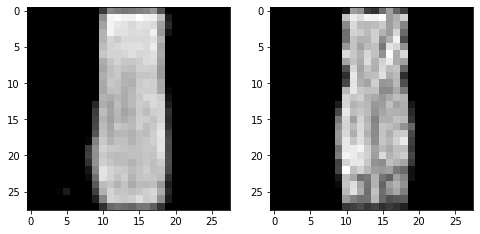

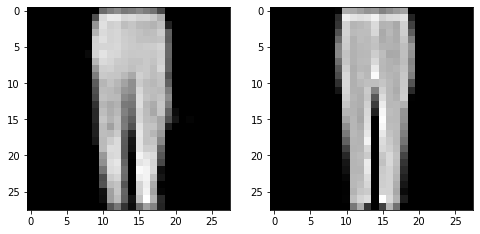

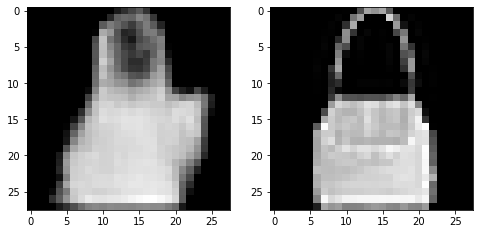

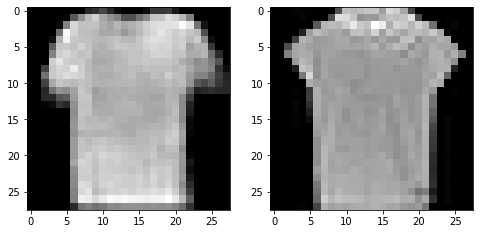

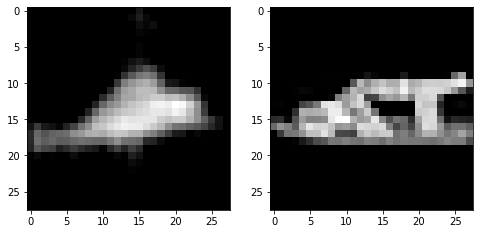

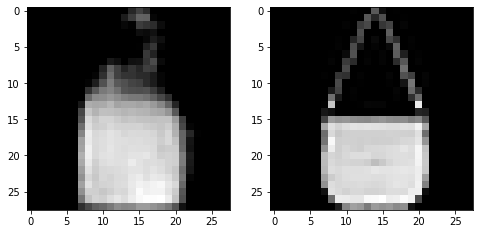

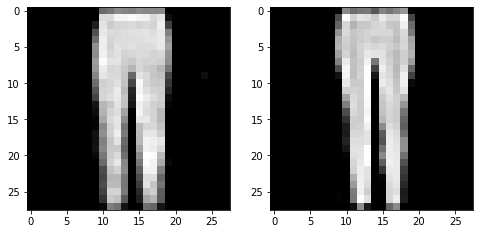

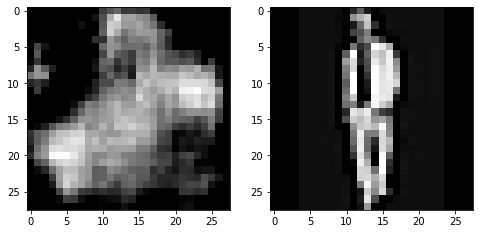

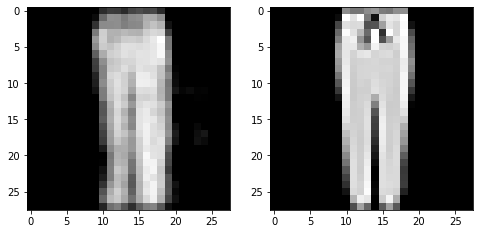

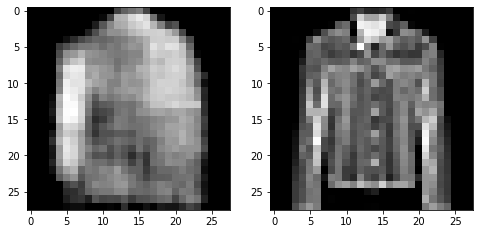

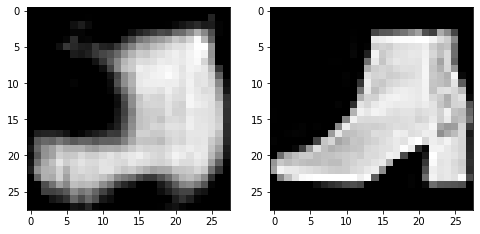

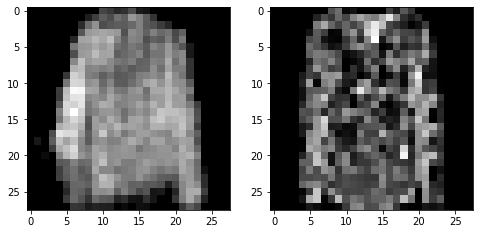

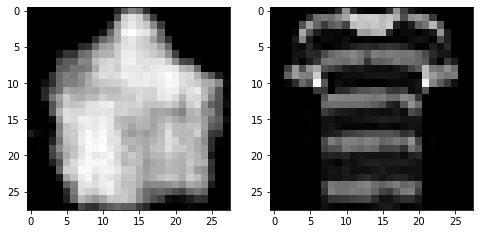

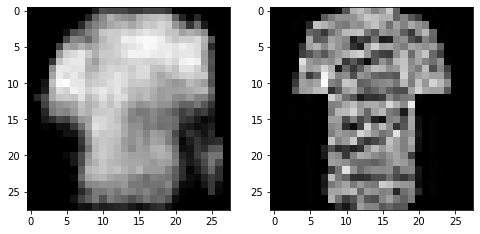

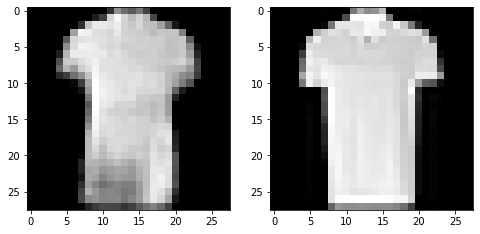

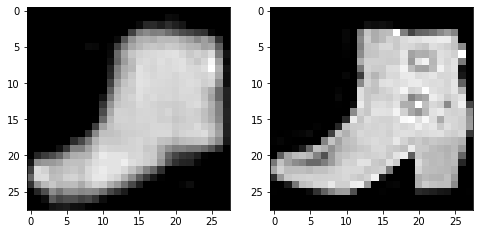

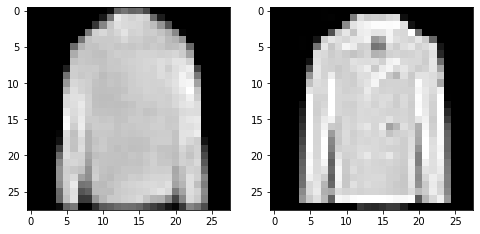

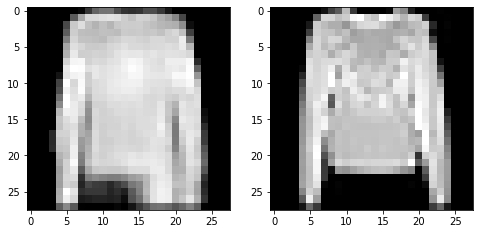

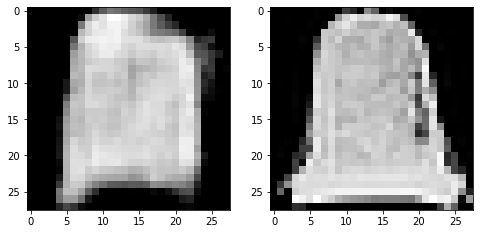

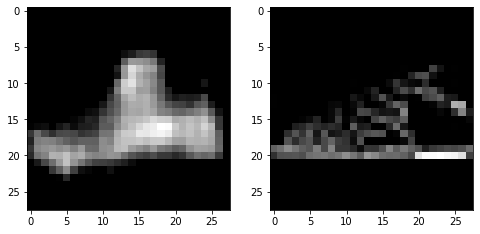

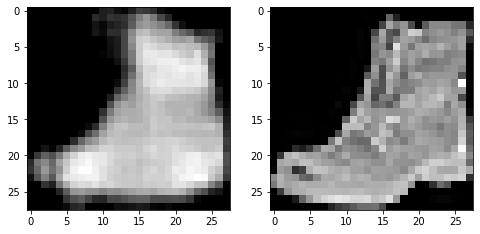

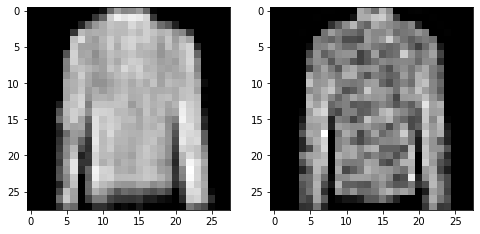

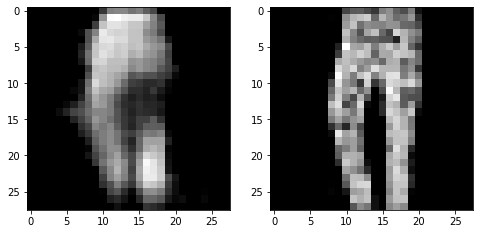

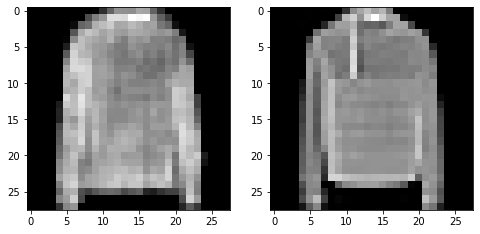

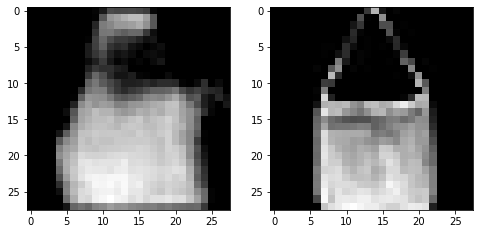

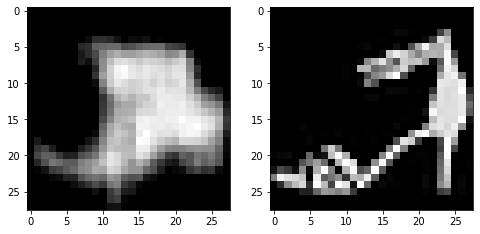

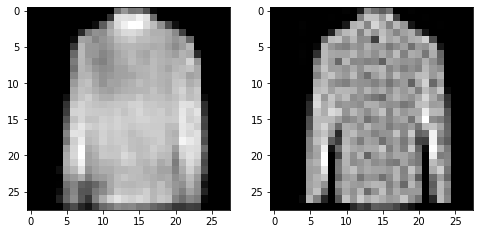

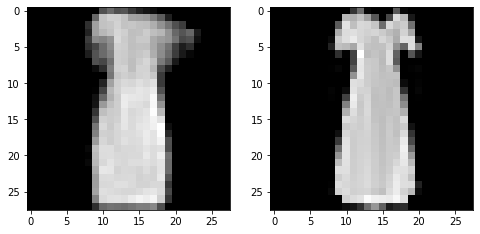

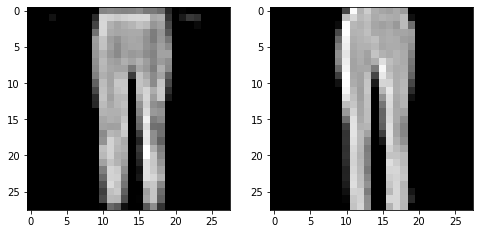

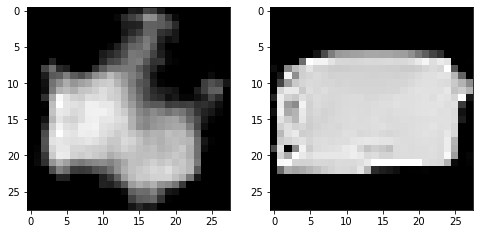

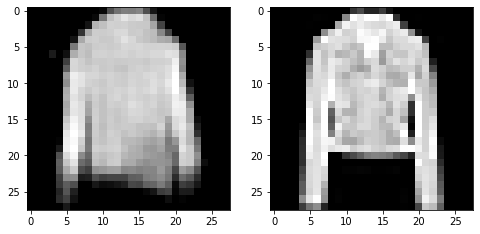

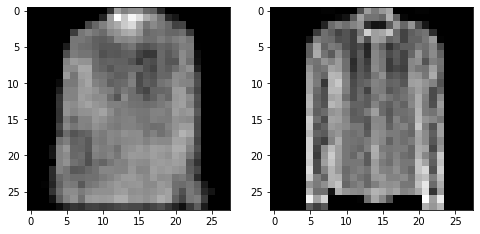

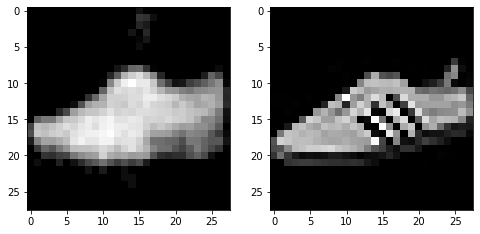

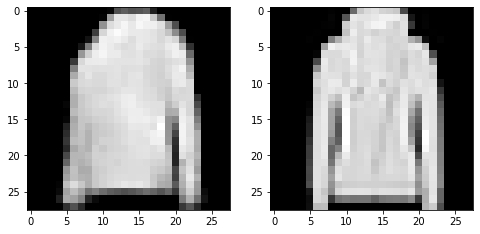

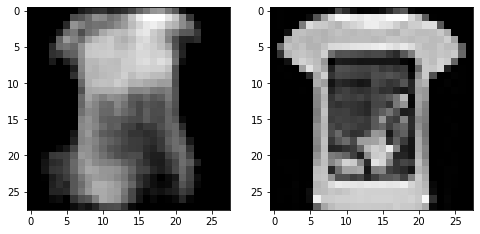

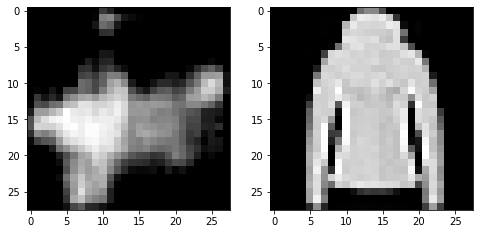

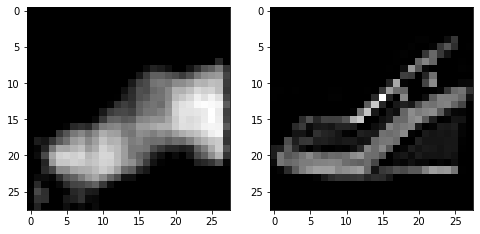

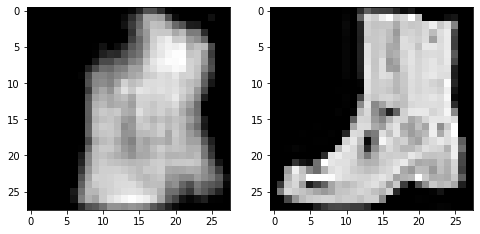

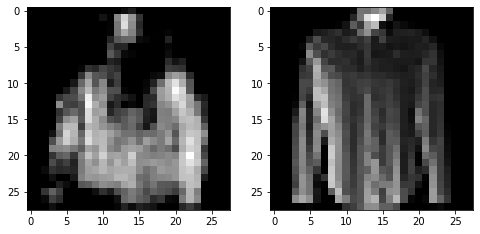

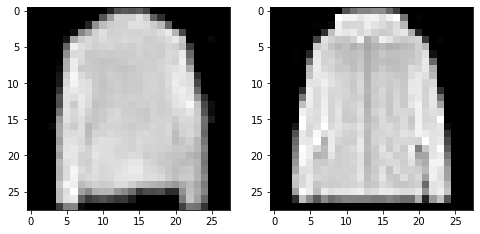

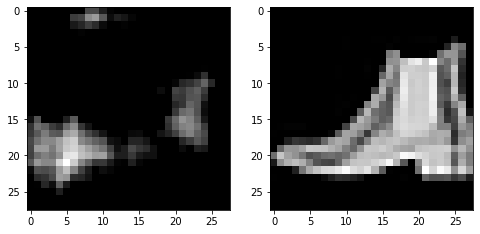

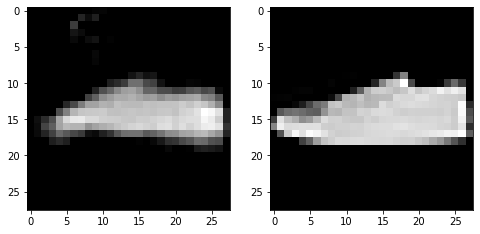

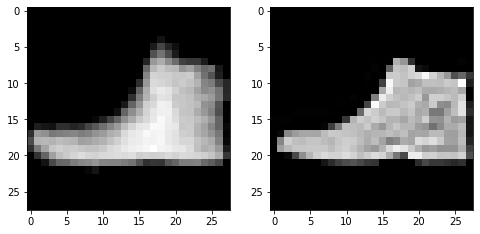

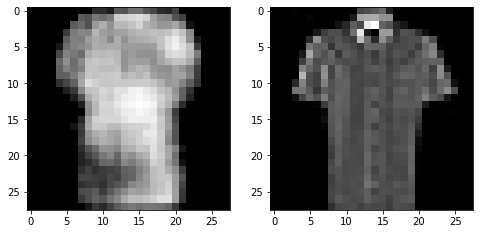

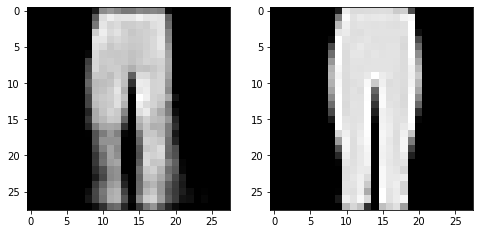

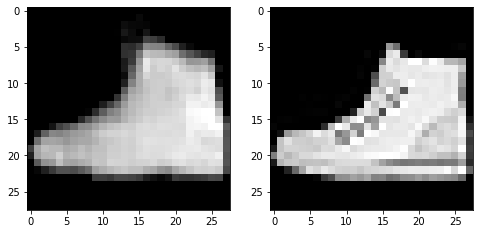

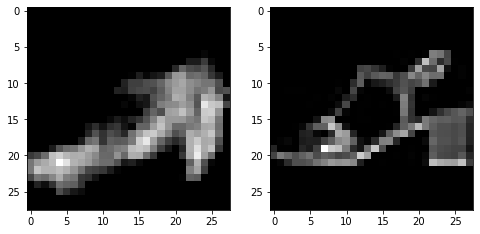

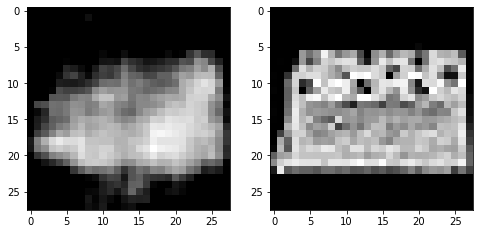

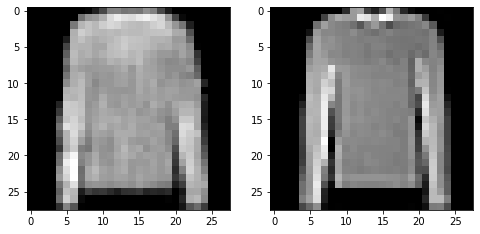

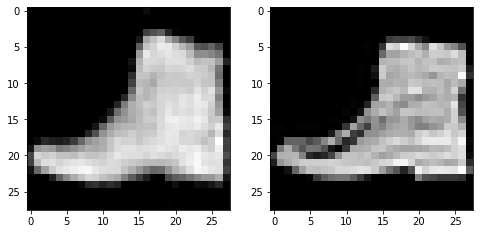

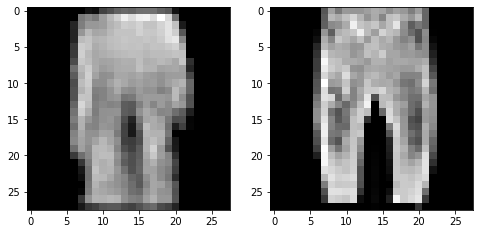

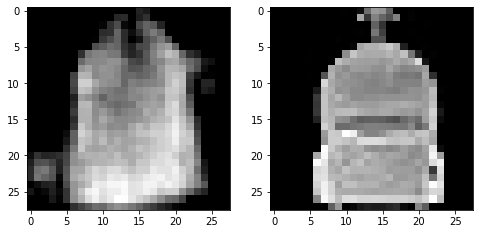

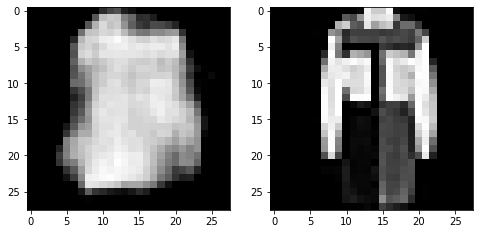

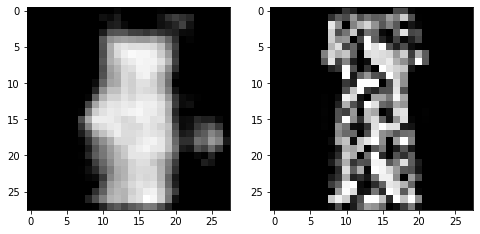

14.742341707771804 0.49789231594911987


In [15]:
imgpath = osp.join(modelsavedir, 'img')
psnrs, ssims = DL.test_decode_model_and_check_img_ver3(mltest, 28, 28, model, device, 8, 4, 1, 100, imgpath, \
                                                label_array = None, datanorm = True, correctimgnorm = True)
meanpsnr = np.mean(np.array(psnrs))
meanssim = np.mean(np.array(ssims))

print(meanpsnr, meanssim)